In [1]:
import gspread
from google.oauth2.service_account import Credentials

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from linkml_runtime.utils.schemaview import SchemaView
import re

import pprint

from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A

In [2]:
schema_with_mam_biased_sels_url = "https://raw.githubusercontent.com/microbiomedata/submission-schema/refs/heads/main/src/nmdc_submission_schema/schema/nmdc_submission_schema.yaml"

In [3]:
sels_enum_name = "EnvLocalScaleSoilEnum"

In [4]:
# 1. Replace with the path to your downloaded JSON key file
SERVICE_ACCOUNT_FILE = 'env-context-voting-sheets-29d0d970ca1d.json'  


In [5]:
## soil-env-local-scale-evidence-table
# SPREADSHEET_ID = "1MChOcbjKEQjsAJlZN8oOlyO3TN09spCnIEAlV8kW1bE"

# Consolidated_soil-env-local-scale-evidence-table
SPREADSHEET_ID = "1epul_bXtEOlmIZYNRhngulI3-HaHhe_tU_BPUia5isQ"


In [6]:
# # Replace 'Your Sheet Name' with the actual name of your sheet
# sheet_name = 'soil-env-local-scale-evidence-table'  

sheet_name = 'soil-env-local-scale-evidence-t'  

In [7]:
# Set up credentials
SCOPES = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]


In [8]:
envo_adapter_string  = "sqlite:obo:envo"

In [9]:
ABP = 'ENVO:01000813'

In [10]:
## code starts here

In [11]:
def compare_curie_dicts(input_dict):
  """
  Compares two dictionaries of curies and labels and reports differences 
  and common elements.

  Args:
    input_dict: A dictionary with two keys representing the group labels and 
                 the values being dictionaries of curie: label pairs.

  Returns:
    A dictionary with three keys:
      - 'first_only': A dictionary of curie: label pairs present only in 
                       the first group.
      - 'second_only': A dictionary of curie: label pairs present only in 
                        the second group.
      - 'shared': A dictionary of curie: label pairs present in both groups.
  """

  group1_label, group1_data = list(input_dict.items())[0]
  group2_label, group2_data = list(input_dict.items())[1]

  first_only_curies = set(group1_data.keys()) - set(group2_data.keys())
  second_only_curies = set(group2_data.keys()) - set(group1_data.keys())
  shared_curies = set(group1_data.keys()) & set(group2_data.keys())

  first_only = {curie: group1_data[curie] for curie in first_only_curies}
  second_only = {curie: group2_data[curie] for curie in second_only_curies}
  shared = {curie: group1_data[curie] for curie in shared_curies}

  return {
      f'{group1_label} only': first_only,
      f'{group2_label} only': second_only,
      'shared': shared
  }

In [12]:
def tabulate_core_ancestor_counts(
    curies,
    adapter,
    predicates=[IS_A],
    omit_max_count=True,
    min_count_threshold=2,
):
    """
    Tabulates the number of times each ancestor curie appears for a list of 
    input curies, with options to exclude maximum counts and a minimum count 
    threshold.

    Args:
      curies: A list of curies to get ancestors for.
      adapter: The adapter object to use for fetching ancestors (e.g., an 
               instance of OntoBiotopeAdapter).
      predicates: A list of predicates to use for traversing the ancestor 
                  hierarchy (default: [IS_A]).
      omit_max_count: Whether to omit rows with the maximum count 
                      (default: True).
      min_count_threshold: The minimum count threshold for excluding rows 
                           (default: 2).

    Returns:
      A pandas DataFrame with three columns:
        - 'ancestor_curie': The ancestor curie.
        - 'ancestor_curie_label': The label of the ancestor curie.
        - 'ancestor_curie_count': The number of times this ancestor appears.
    """

    ancestor_counts = {}
    for curie in curies:
        ancestors = adapter.ancestors(curie, predicates=predicates)
        for ancestor_curie in ancestors:
            if ancestor_curie not in ancestor_counts:
                ancestor_counts[ancestor_curie] = {
                    'ancestor_curie_label': adapter.label(ancestor_curie),
                    'ancestor_curie_count': 0
                }
            ancestor_counts[ancestor_curie]['ancestor_curie_count'] += 1

    df = pd.DataFrame(ancestor_counts).transpose().reset_index()

    # Apply filtering
    if omit_max_count:
        max_count = df['ancestor_curie_count'].max()
        df = df[df['ancestor_curie_count'] != max_count]

    df = df[df['ancestor_curie_count'] >= min_count_threshold]
    
    df = df.sort_values(by='ancestor_curie_count', ascending=False)

    return df

In [13]:

def check_descendants(curies, root_curie, adapter):
    """
    Determines whether a list of curies are descendants of a given root curie.

    Args:
      curies: A list of curies to check.
      root_curie: The curie of the root class.
      adapter: The adapter object to use for fetching ancestors and labels.

    Returns:
      A pandas DataFrame with three columns:
        - 'curie': The input curie.
        - 'label': The label of the input curie.
        - 'is_{root_label_in_snake_case}': Boolean indicating whether the 
                                          curie is a descendant of the root.
    """

    root_label_snake_case = adapter.label(root_curie).lower().replace(" ", "_")
    is_descendant_column = f'is_{root_label_snake_case}'

    results = []
    for curie in curies:
        ancestors = adapter.ancestors(curie)
        is_descendant = root_curie in ancestors
        results.append({
            'curie': curie,
            'label': adapter.label(curie),
            is_descendant_column: is_descendant
        })

    return pd.DataFrame(results)

In [14]:
envo_adapter = get_adapter(envo_adapter_string)

In [15]:
creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)

In [16]:
gc = gspread.authorize(creds)

In [17]:
# Open the spreadsheet
spreadsheet = gc.open_by_key(SPREADSHEET_ID) 

In [18]:
sheet = spreadsheet.worksheet(sheet_name)

In [19]:
# Get data as a list of lists
data = sheet.get_all_values()

In [20]:
# Convert to DataFrame
df = pd.DataFrame(data[1:], columns=data[0]) 

In [21]:
df

,unique_id,label,all_evidence,is_process,is_quality,is_chemical_entity,is_biome,is_aquatic_biome,is_terrestrial_biome,is_environmental_material,...,MLS_vote,MLS_comments,NMW_vote,NMW_comment,SM_vote,SM_comment,Yes = 1 No = -1 Maybe = 0,IAA_score,vote_sum,was_subjected_to_voting
0,CHEBI:24632,hydrocarbon,0.003288752467,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
1,CHEBI:24866,salt,0.0001096250822,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
2,CHEBI:25555,nitrogen atom,0.0006577504933,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
3,CHEBI:26833,sulfur atom,0.0001096250822,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
4,CHEBI:33287,fertilizer,0.03672440254,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,-1,,,,,,-3,0.4,-3,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,ENVO:00000567,calanque,,,,,,,,,...,,,,,,,,0.4,-2,FALSE
1225,ENVO:03500004,bike path,,,,,,,,,...,,,,,,,,0.4,-2,FALSE
1226,ENVO:03501248,overpass,,,,,,,,,...,,,,,,,,0.4,-2,FALSE
1227,ENVO:00000561,military training area,,,,,,,,,...,,,,,,,,0.4,-2,FALSE


In [22]:
df.columns

Index(['unique_id', 'label', 'all_evidence', 'is_process', 'is_quality',
       'is_chemical_entity', 'is_biome', 'is_aquatic_biome',
       'is_terrestrial_biome', 'is_environmental_material', 'is_soil',
       'is_enriched_soil', 'obsolete', 'non_host_oak_queries_count',
       'historical_permissible_values_count', 'NMDC_soil_count',
       'NCBI_mims_soil_trusting_CURIe_count',
       'NCBI_mims_soil_trusting_labels_count', 'GOLD_env_terr_soil_count',
       'non_host_oak_queries_frequency',
       'historical_permissible_values_frequency', 'NMDC_soil_frequency',
       'NCBI_mims_soil_trusting_CURIe_frequency',
       'NCBI_mims_soil_trusting_labels_frequency',
       'GOLD_env_terr_soil_frequency', 'CJM_Vote', 'CJM_Comments', 'MAM vote',
       'MAM comments', 'MLS_vote', 'MLS_comments', 'NMW_vote', 'NMW_comment',
       'SM_vote', 'SM_comment', 'Yes = 1 No = -1 Maybe = 0', 'IAA_score',
       'vote_sum', 'was_subjected_to_voting'],
      dtype='object')

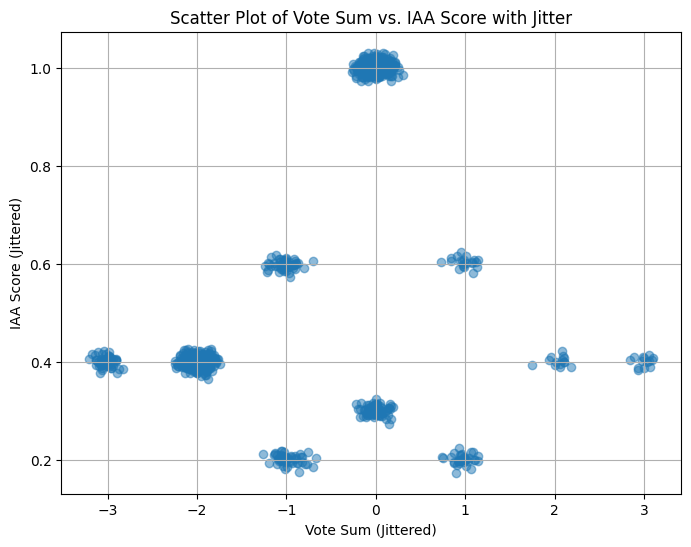

In [23]:
# Convert 'vote_sum' to numeric
df['vote_sum'] = pd.to_numeric(df['vote_sum'], errors='coerce')

# Convert 'IAA_score' to numeric  <--- Add this line
df['IAA_score'] = pd.to_numeric(df['IAA_score'], errors='coerce') 

# Add jitter to 'vote_sum' and 'IAA_score'
df['vote_sum_jittered'] = df['vote_sum'] + np.random.normal(0, 0.1, size=len(df))
df['IAA_score_jittered'] = df['IAA_score'] + np.random.normal(0, 0.01, size=len(df))


# Scatter plot with jittered values
plt.figure(figsize=(8, 6))
plt.scatter(df['vote_sum_jittered'], df['IAA_score_jittered'], alpha=0.5)
plt.xlabel('Vote Sum (Jittered)')
plt.ylabel('IAA Score (Jittered)')
plt.title('Scatter Plot of Vote Sum vs. IAA Score with Jitter')
plt.grid(True)
plt.show()

In [24]:
# Group by 'vote_sum' and 'IAA_score' and count the occurrences
count_table = df.groupby(['vote_sum', 'IAA_score']).size().reset_index(name='count')

In [25]:
count_table

,vote_sum,IAA_score,count
0,-3,0.4,56
1,-2,0.4,404
2,-1,0.2,54
3,-1,0.6,51
4,0,0.3,72
5,0,1.0,509
6,1,0.2,34
7,1,0.6,21
8,2,0.4,14
9,3,0.4,14


In [26]:
# Set your thresholds
vote_sum_threshold = 1  # Example threshold
IAA_score_threshold = 0.0  # Example threshold

In [27]:
# Create the derived DataFrame
vote_filtered_df = df[(df['vote_sum'] >= vote_sum_threshold) & (df['IAA_score'] >= IAA_score_threshold)]

In [28]:
vote_filtered_df

,unique_id,label,all_evidence,is_process,is_quality,is_chemical_entity,is_biome,is_aquatic_biome,is_terrestrial_biome,is_environmental_material,...,NMW_vote,NMW_comment,SM_vote,SM_comment,Yes = 1 No = -1 Maybe = 0,IAA_score,vote_sum,was_subjected_to_voting,vote_sum_jittered,IAA_score_jittered
18,ENVO:00000011,garden,0.1188080752,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.2,1,,0.986695,0.205407
20,ENVO:00000014,canal,0.00885439641,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,0.912217,0.615091
24,ENVO:00000020,lake,0.02299603202,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,1.087127,0.580855
26,ENVO:00000022,river,0.0144452756,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,3,0.4,3,,2.994354,0.410096
27,ENVO:00000023,stream,0.008964021492,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,2,0.4,2,,2.058657,0.389669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,ENVO:01001568,frost heave,0.00885439641,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,0.986883,0.606748
1072,ENVO:01001803,tropical forest,0.04140378549,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.2,1,,0.879307,0.193565
1115,ENVO:03000117,channel,0.01770879282,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,2,0.4,2,,2.111096,0.408144
1119,ENVO:03500005,anthropogenic litter,0.00885439641,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,1.118178,0.603857


In [29]:
schema_with_mam_biased_sels_url = SchemaView(schema_with_mam_biased_sels_url)

In [30]:
mam_biased_sels_enum = schema_with_mam_biased_sels_url.get_enum(sels_enum_name)

In [31]:
mam_biased_sels_enum_pvs = list(mam_biased_sels_enum.permissible_values.keys())

In [32]:
mam_biased_curie_label_dict = {}
for label_with_curie in mam_biased_sels_enum_pvs:
    match = re.search(r'(.*?) \[(.*?)\]', label_with_curie)  # Extract label and curie
    if match:
        label = match.group(1)
        curie = match.group(2)
        mam_biased_curie_label_dict[curie] = label


In [33]:
# Create the curie dictionary from filtered_df
votes_only_dict = dict(zip(vote_filtered_df['unique_id'], vote_filtered_df['label']))

In [34]:
input_data = {'MAM biased': mam_biased_curie_label_dict, 'Votes': votes_only_dict}

In [35]:
pvs_analysis = compare_curie_dicts(input_data)

In [36]:
pprint.pprint(pvs_analysis)

{'MAM biased only': {'ENVO:00000064': 'road',
                     'ENVO:00000074': 'dam',
                     'ENVO:00000100': 'valley',
                     'ENVO:00000108': 'meadow ecosystem',
                     'ENVO:00000127': 'badland',
                     'ENVO:00000169': 'canyon',
                     'ENVO:00000177': 'moraine',
                     'ENVO:00000181': 'nunatak',
                     'ENVO:00000276': 'drumlin',
                     'ENVO:00000277': 'dry lake',
                     'ENVO:00000280': 'escarpment',
                     'ENVO:00000282': 'esker',
                     'ENVO:00000300': 'scrubland area',
                     'ENVO:00000304': 'shore',
                     'ENVO:00000320': 'crevasse',
                     'ENVO:00000325': 'polje',
                     'ENVO:00000370': 'tuya',
                     'ENVO:00000410': 'kipuka',
                     'ENVO:00000417': 'machair',
                     'ENVO:00000418': 'ria',
                     '

In [37]:
# list(pvs_analysis['MAM biased only'].keys())

In [40]:
# list(pvs_analysis['Votes only'].keys())

In [39]:
# list(pvs_analysis['shared'].keys())

In [42]:
# for i in list(votes_only_dict.keys()):
#     print(i)

## tried to make a runoak viz but it's just to busy

## Mark's judgement: focus on ABPs and Environmental systems
they're not identified on this sheet

In [43]:
ancestor_frame = tabulate_core_ancestor_counts(list(votes_only_dict.keys()), envo_adapter)

In [44]:
ancestor_frame

# there are limits to how useful this is for picking a root for ELS

,index,ancestor_curie_label,ancestor_curie_count
4,BFO:0000040,material entity,82
7,ENVO:01000813,astronomical body part,70
16,ENVO:01001784,compound astronomical body part,46
27,ENVO:00000191,solid astronomical body part,39
29,ENVO:01001886,landform,35
...,...,...,...
72,ENVO:00000096,caldera,2
69,ENVO:00000087,cliff,2
64,ENVO:00000081,mountain,2
63,ENVO:01001828,anthropised ecosystem,2


In [45]:
is_abp_df = check_descendants(list(votes_only_dict.keys()), ABP, envo_adapter)

In [46]:
is_abp_df

,curie,label,is_astronomical_body_part
0,ENVO:00000011,garden,True
1,ENVO:00000014,canal,True
2,ENVO:00000020,lake,True
3,ENVO:00000022,river,True
4,ENVO:00000023,stream,True
...,...,...,...
78,ENVO:01001568,frost heave,True
79,ENVO:01001803,tropical forest,True
80,ENVO:03000117,channel,True
81,ENVO:03500005,anthropogenic litter,False


In [47]:
not_abp = is_abp_df.loc[~is_abp_df['is_astronomical_body_part'], 'curie'].tolist()

In [48]:
not_abp

['ENVO:00000133', 'ENVO:00005803', 'ENVO:03500005']

In [49]:
non_abp_ancestor_frame = tabulate_core_ancestor_counts(not_abp, envo_adapter, min_count_threshold=1, omit_max_count=False)

In [50]:
non_abp_ancestor_frame

,index,ancestor_curie_label,ancestor_curie_count
1,BFO:0000001,entity,3
2,BFO:0000002,continuant,3
3,BFO:0000004,independent continuant,3
5,BFO:0000040,material entity,3
0,ENVO:00000133,glacier,2
8,ENVO:00005803,animal habitation,2
10,ENVO:03500005,anthropogenic litter,2
4,BFO:0000030,object,1
6,ENVO:01001686,mass of environmental material,1
7,ENVO:01001691,mass of compounded environmental materials,1
